
训练数据缺失值：
Series([], dtype: int64)
测试数据缺失值：
Series([], dtype: int64)


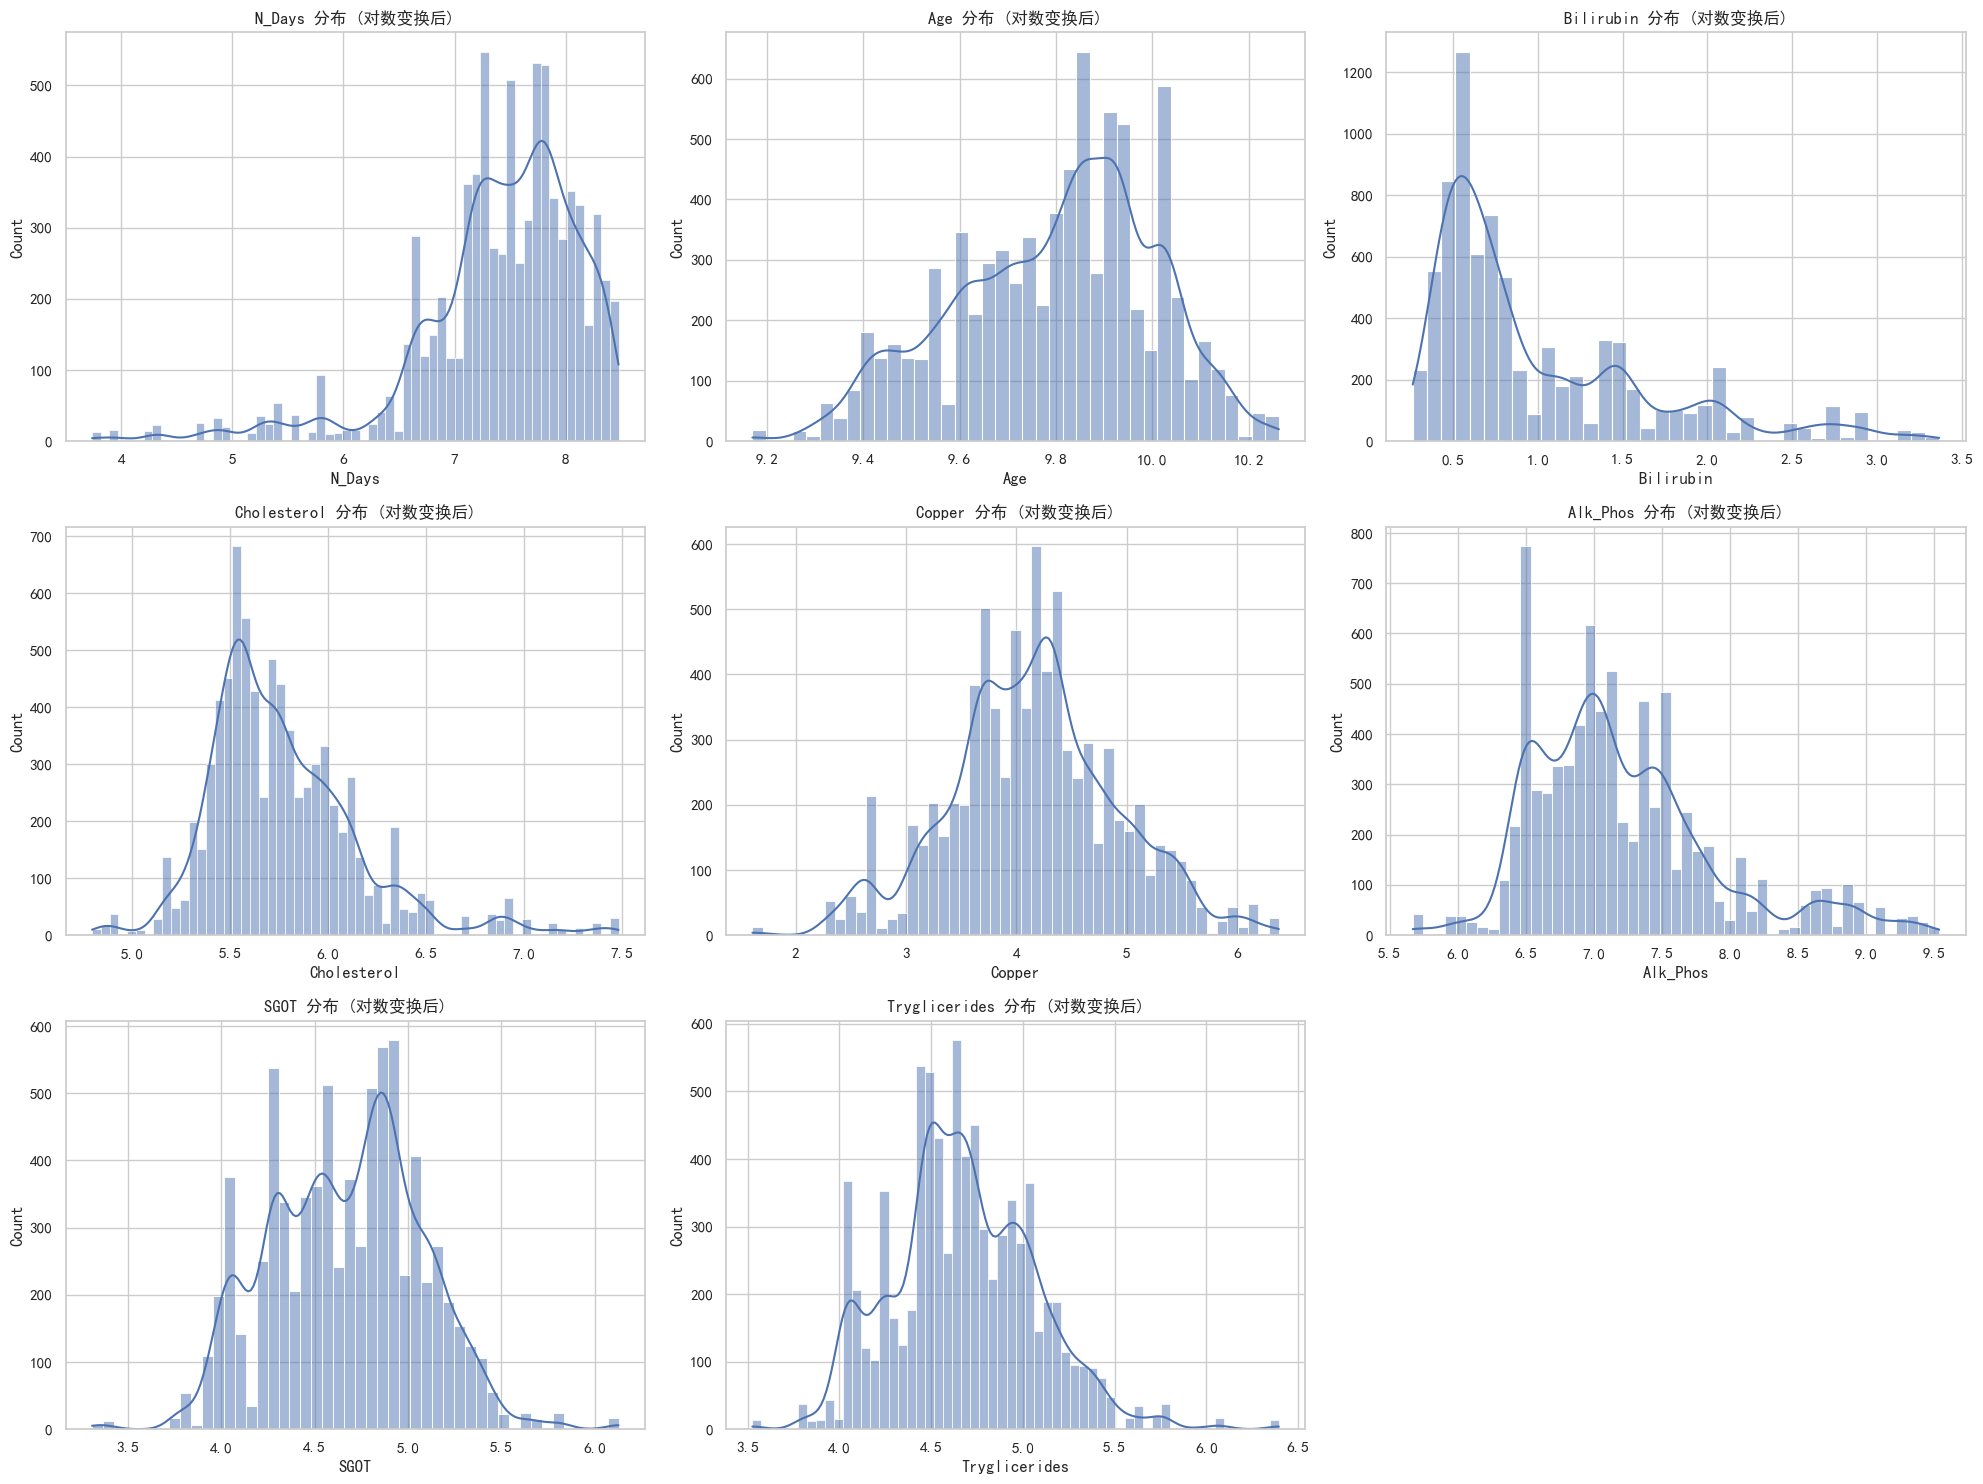



Epoch 1/100


99/99 [==============================] - 1s 3ms/step - loss: 0.9368 - accuracy: 0.5799 - val_loss: 0.6761 - val_accuracy: 0.7647
Epoch 2/100
99/99 [==============================] - 0s 1ms/step - loss: 0.7268 - accuracy: 0.6828 - val_loss: 0.5865 - val_accuracy: 0.7900
Epoch 3/100
99/99 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.7288 - val_loss: 0.5669 - val_accuracy: 0.7951
Epoch 4/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.7441 - val_loss: 0.5539 - val_accuracy: 0.7995
Epoch 5/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6592 - accuracy: 0.7438 - val_loss: 0.5520 - val_accuracy: 0.8014
Epoch 6/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6405 - accuracy: 0.7627 - val_loss: 0.5412 - val_accuracy: 0.8033
Epoch 7/100
99/99 [==============================] - 0s 1ms/step - loss: 0.6256 - accuracy: 0.7655 - val_loss: 0.5421 - val_accuracy: 0.8020
Epoch 8/1

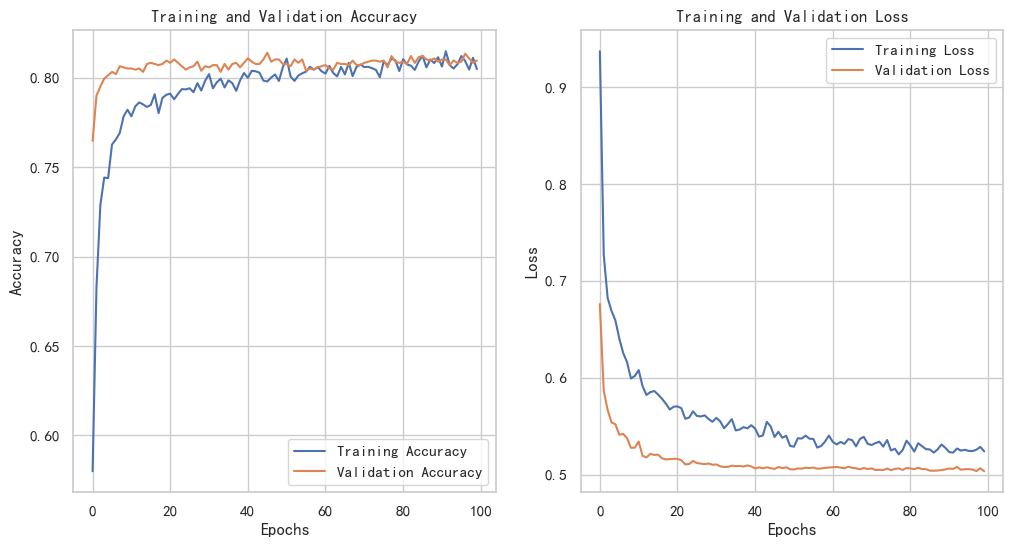

165/165 [==============================] - 0s 710us/step


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.impute import SimpleImputer

# 设置Seaborn的样式
sns.set(style="whitegrid")

# 设置字体样式
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 加载数据
train_data = pd.read_csv('C:\\Users\\杰与辉\\Desktop\\深度学习\\train.csv', encoding='utf-8')
test_data = pd.read_csv('C:\\Users\\杰与辉\\Desktop\\深度学习\\test.csv', encoding='utf-8')

# 检查缺失值
missing_train = train_data.isnull().sum()
missing_test = test_data.isnull().sum()
print(f"训练数据缺失值：\n{missing_train[missing_train > 0]}")
print(f"测试数据缺失值：\n{missing_test[missing_test > 0]}")

# 定义分类和二元特征
categorical_features_onehot = ['Drug']
binary_features = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
numerical_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

# 缺失值处理
# 用均值填补数值型特征
imputer_num = SimpleImputer(strategy='mean')
train_data[numerical_columns] = imputer_num.fit_transform(train_data[numerical_columns])
test_data[numerical_columns] = imputer_num.transform(test_data[numerical_columns])

# 用众数填补分类特征
imputer_cat = SimpleImputer(strategy='most_frequent')
train_data[categorical_features_onehot + binary_features] = imputer_cat.fit_transform(train_data[categorical_features_onehot + binary_features])
test_data[categorical_features_onehot + binary_features] = imputer_cat.transform(test_data[categorical_features_onehot + binary_features])

# 对数变换
log_transform_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides']
for col in log_transform_columns:
    train_data[col] = np.log1p(train_data[col])
    test_data[col] = np.log1p(test_data[col])

# 可视化对数变换后的特征分布
plt.figure(figsize=(20, 15))
for i, col in enumerate(log_transform_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_data[col], kde=True)
    plt.title(f'{col} 分布 (对数变换后)', fontsize=12)
plt.tight_layout()
plt.show()

# 数据准备
X_train = train_data.drop(['id', 'Status'], axis=1)
y_train = train_data['Status']
X_test = test_data.drop('id', axis=1)

# 预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_features_onehot)
    ])

# 应用预处理
X_train_processed = preprocessor.fit_transform(X_train)
y_train_encoded = LabelEncoder().fit_transform(y_train)
X_test_processed = preprocessor.transform(X_test)

# 模型构建
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# 模型编译
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 模型训练
history = model.fit(X_train_processed, y_train_encoded,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)

# 可视化训练过程
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 预测并生成提交文件
y_probs = model.predict(X_test_processed)
submission = pd.DataFrame({
    'id': test_data['id'],
    'Status_C': y_probs[:, 0],
    'Status_CL': y_probs[:, 1],
    'Status_D': y_probs[:, 2]
})
submission.to_csv('C:\\Users\\杰与辉\\Desktop\\深度学习\\submission.csv', index=False)
